In [2]:
%load_ext autoreload
%autoreload 2

## Libraries

In [3]:
# Librerías estándar
import math

# Librerías de terceros: manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Importaciones específicas del proyecto
from lightweight_clustered_energy_forecasts.utils.paths import data_dir


## Funciones auxiliares

## Clustering

In [4]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"])

In [5]:
# Extract the date part from the timestamp and group by day
building_11a['date'] = building_11a['timestamp'].dt.date

# Create a dictionary with each day as a key and its 15-minute consumption data as a value
daily_data = {date: group['kwh'].reset_index(drop=True) 
              for date, group in building_11a.groupby('date')}

# Check the resulting structure by inspecting one example day
example_day = list(daily_data.keys())[0], daily_data[list(daily_data.keys())[0]].head()
example_day



(datetime.date(2023, 1, 1),
 0    15.66
 1    15.39
 2    12.59
 3    11.26
 4    16.10
 Name: kwh, dtype: float64)

### Time domain features

In [6]:
# Initialize an empty list to store the features
features = []

# Extract time-domain features for each day
for date, kwh_series in daily_data.items():
    total_consumption = kwh_series.sum()
    average_consumption = kwh_series.mean()
    peak_consumption = kwh_series.max()
    off_peak_consumption = kwh_series.min()
    variability = kwh_series.std()
    # Adding the day-specific features to the list
    features.append({
        'date': date,
        'total_consumption': total_consumption,
        'average_consumption': average_consumption,
        'peak_consumption': peak_consumption,
        'off_peak_consumption': off_peak_consumption,
        'variability': variability,
    })

# Convert the feature list into a DataFrame
time_features_df = pd.DataFrame(features)

# Display the time-domain features to the user
time_features_df.head()


,date,total_consumption,average_consumption,peak_consumption,off_peak_consumption,variability
0,2023-01-01,1360.28,14.169583,17.50,8.82,1.931145
1,2023-01-02,1387.56,14.453750,16.86,11.34,1.504416
2,2023-01-03,4592.01,47.833438,115.55,10.24,34.260109
3,2023-01-04,4166.61,43.402187,113.74,10.70,34.191510
4,2023-01-05,4007.76,41.747500,114.75,10.57,34.083826


### Frecuency domain features

In [7]:
from scipy.fft import fft
from scipy.stats import entropy

# Define a function to compute spectral entropy
def spectral_entropy(power_spectrum):
    prob_distribution = power_spectrum / np.sum(power_spectrum)
    return entropy(prob_distribution)

In [8]:
# Fix the data structure for FFT by converting the Series to a numpy array
# and retrying the frequency domain feature extraction

frequency_features = []
# Sampling frequency (15-minute intervals = 4 samples/hour, 96 samples/day)
fs = 96
for date, kwh_series in daily_data.items():
    # Convert to numpy array for compatibility
    kwh_array = kwh_series.values
    
    # Perform FFT
    fft_result = fft(kwh_array)
    power_spectrum = np.abs(fft_result) ** 2
    freqs = np.fft.fftfreq(len(kwh_array), d=1/fs)
    
    # Retain only the positive frequencies
    positive_freqs = freqs[freqs >= 0]
    positive_power = power_spectrum[freqs >= 0]
    
    # Compute features
    dominant_frequency = positive_freqs[np.argmax(positive_power)]
    spectral_energy = np.sum(positive_power)
    spec_entropy = spectral_entropy(positive_power)
    
    # Append the results
    frequency_features.append({
        'date': date,
        'dominant_frequency': dominant_frequency,
        'spectral_energy': spectral_energy,
        'spectral_entropy': spec_entropy,
    })

# Convert the frequency feature list into a DataFrame
frequency_features_df = pd.DataFrame(frequency_features)


frequency_features_df.head()


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11392\3634169957.py:6: RuntimeWarning: invalid value encountered in divide
  prob_distribution = power_spectrum / np.sum(power_spectrum)


,date,dominant_frequency,spectral_energy,spectral_entropy
0,2023-01-01,0.0,1.867228e+06,0.080733
1,2023-01-02,0.0,1.935594e+06,0.051259
2,2023-01-03,0.0,2.643886e+07,0.696863
3,2023-01-04,0.0,2.269097e+07,0.729429
4,2023-01-05,0.0,2.135936e+07,0.745807


### combining features

In [9]:
# Combine the time-domain and frequency-domain features by merging on the 'date' column
combined_features_df = pd.merge(time_features_df, frequency_features_df, on='date')

combined_features_df.head()

,date,total_consumption,average_consumption,peak_consumption,off_peak_consumption,variability,dominant_frequency,spectral_energy,spectral_entropy
0,2023-01-01,1360.28,14.169583,17.50,8.82,1.931145,0.0,1.867228e+06,0.080733
1,2023-01-02,1387.56,14.453750,16.86,11.34,1.504416,0.0,1.935594e+06,0.051259
2,2023-01-03,4592.01,47.833438,115.55,10.24,34.260109,0.0,2.643886e+07,0.696863
3,2023-01-04,4166.61,43.402187,113.74,10.70,34.191510,0.0,2.269097e+07,0.729429
4,2023-01-05,4007.76,41.747500,114.75,10.57,34.083826,0.0,2.135936e+07,0.745807


In [10]:
feature_columns = [
    'total_consumption', 'average_consumption', 'peak_consumption',
    'off_peak_consumption', 'variability', 'dominant_frequency',
    'spectral_energy', 'spectral_entropy'
]
# Check for missing values in the combined dataset
missing_summary = combined_features_df[feature_columns].isna().sum()

# Display missing value summary
missing_summary


total_consumption        0
average_consumption      0
peak_consumption         0
off_peak_consumption     0
variability              0
dominant_frequency       0
spectral_energy          0
spectral_entropy        49
dtype: int64

In [11]:
# Impute missing values in the 'spectral_entropy' feature with the mean
combined_features_df['spectral_entropy'].fillna(
    combined_features_df['spectral_entropy'].mean(), inplace=True
)


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11392\1499239373.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_features_df['spectral_entropy'].fillna(


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalize the features (excluding the 'date' column)
feature_columns = [
    'total_consumption', 'average_consumption', 'peak_consumption',
    'off_peak_consumption', 'variability', 'dominant_frequency',
    'spectral_energy', 'spectral_entropy'
]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(combined_features_df[feature_columns])

# Apply K-Means clustering (let's start with a range of clusters and find the best number)
silhouette_scores = []
inertia_values = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_features)
    silhouette_avg = silhouette_score(normalized_features, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))
    inertia_values.append((n_clusters, kmeans.inertia_))  # Store inertia for each cluster count

# Find the number of clusters with the highest silhouette score
best_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\U

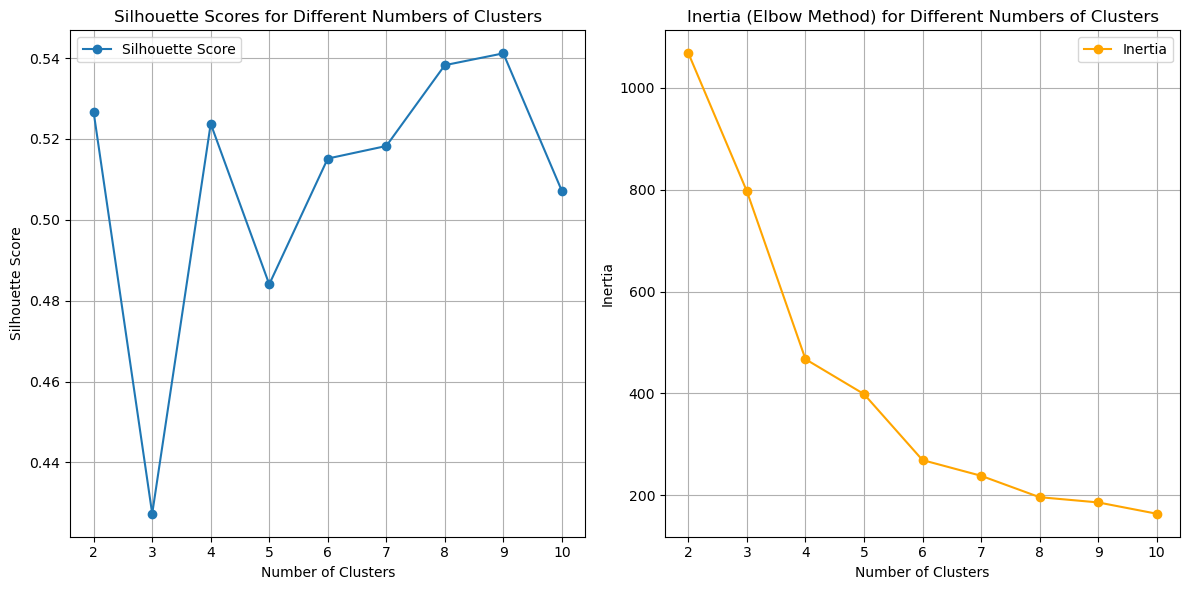

In [13]:

# Plot Silhouette Scores and Inertia
plt.figure(figsize=(12, 6))

# Silhouette Scores Plot
plt.subplot(1, 2, 1)
plt.plot(cluster_range, [score[1] for score in silhouette_scores], marker='o', label='Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()

# Inertia Plot
plt.subplot(1, 2, 2)
plt.plot(cluster_range, [inertia[1] for inertia in inertia_values], marker='o', label='Inertia', color='orange')
plt.title('Inertia (Elbow Method) for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [14]:

# Refit K-Means with the optimal number of clusters
#kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_features)

# Add the cluster labels to the original dataframe
combined_features_df['cluster'] = cluster_labels


c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


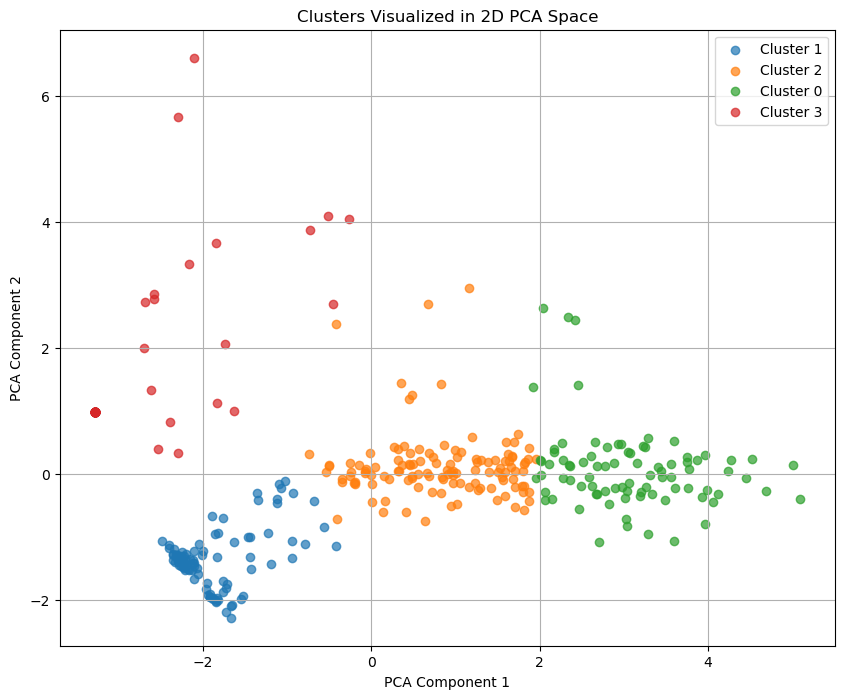

In [15]:
from sklearn.decomposition import PCA

# Reduce the feature space to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

# Add the PCA components to the dataframe for plotting
combined_features_df['pca_1'] = reduced_features[:, 0]
combined_features_df['pca_2'] = reduced_features[:, 1]

# Plot the clusters in the reduced 2D space
plt.figure(figsize=(10, 8))
for cluster in combined_features_df['cluster'].unique():
    cluster_data = combined_features_df[combined_features_df['cluster'] == cluster]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('Clusters Visualized in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Summarize the characteristics of each cluster by calculating feature means
cluster_summary = combined_features_df.groupby('cluster')[feature_columns].mean()

# Add the count of days in each cluster
cluster_summary['days_in_cluster'] = combined_features_df['cluster'].value_counts()

cluster_summary


,total_consumption,average_consumption,peak_consumption,off_peak_consumption,variability,dominant_frequency,spectral_energy,spectral_entropy,days_in_cluster
cluster,,,,,,,,,
0,5449.906235,56.769857,168.798000,11.785294,52.335630,0.0,4.273870e+07,0.877893,85
1,1598.134667,16.647236,27.929889,10.923333,4.264989,0.0,2.847105e+06,0.191166,90
2,3732.670560,38.881985,112.745738,9.670984,32.697992,0.0,1.942435e+07,0.832130,122
3,272.231275,2.835742,14.292157,0.000000,3.320402,0.0,6.868449e+05,0.969572,68


In [17]:
# Prepare the original dataset with the cluster assignments
original_with_clusters = pd.merge(building_11a, combined_features_df[['date', 'cluster']], on='date', how='left')


original_with_clusters.head()


,timestamp,kwh,date,cluster
0,2023-01-01 00:00:00+00:00,15.66,2023-01-01,1
1,2023-01-01 00:15:00+00:00,15.39,2023-01-01,1
2,2023-01-01 00:30:00+00:00,12.59,2023-01-01,1
3,2023-01-01 00:45:00+00:00,11.26,2023-01-01,1
4,2023-01-01 01:00:00+00:00,16.10,2023-01-01,1


In [18]:
# Extract month and day of the week for analysis
original_with_clusters['month'] = original_with_clusters['timestamp'].dt.month
original_with_clusters['day_of_week'] = original_with_clusters['timestamp'].dt.day_name()

# Count occurrences of each cluster per month
cluster_month_analysis = original_with_clusters.groupby(['month', 'cluster']).size().unstack(fill_value=0)

# Count occurrences of each cluster per day of the week
cluster_day_analysis = original_with_clusters.groupby(['day_of_week', 'cluster']).size().unstack(fill_value=0)

# Sort days of the week in a logical order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cluster_day_analysis = cluster_day_analysis.reindex(days_order)


(cluster_month_analysis, cluster_day_analysis)


(cluster     0     1     2     3
 month                          
 1         192   864  1728   192
 2           0   960  1728     0
 3           0   288   960  1728
 4           0   960  1920     0
 5         864   384   768   960
 6        1152   384   960   384
 7         960   960   960    96
 8         864  1152   672   288
 9         384   384  1344   768
 10        864   384   288  1440
 11       1632   864   288    96
 12       1248  1056    96   576,
 cluster         0     1     2     3
 day_of_week                        
 Monday       1440   672  1728  1152
 Tuesday      2016   288  1920   768
 Wednesday    1920   288  2208   576
 Thursday     1728   384  2112   768
 Friday       1056   480  2784   672
 Saturday        0  2880   960  1152
 Sunday          0  3648     0  1440)

### Analysis of Clusters

#### **Cluster 0: High Consumption Cluster**
- **Characteristics**:
  - Total Consumption: **5449.91 kWh** (highest).
  - Average Consumption: **56.77 kWh/day**.
  - Peak Consumption: **168.80 kWh** (very high peaks).
  - Variability: **52.34 kWh** (significant daily fluctuations).
  - Spectral Entropy: **0.878** (complex patterns).
- **Trends**:
  - Predominantly seen in **winter months (November-December)** and **summer months (June-July)**.
  - Associated with **weekdays** (Tuesday through Friday).
- **Insights**:
  - Represents days with high energy demand, possibly due to cooling/heating systems during extreme weather or industrial operations.

---

#### **Cluster 1: Moderate and Stable Consumption**
- **Characteristics**:
  - Total Consumption: **1598.13 kWh** (moderate).
  - Average Consumption: **16.65 kWh/day**.
  - Peak Consumption: **27.93 kWh** (low peaks).
  - Variability: **4.26 kWh** (stable daily consumption).
  - Spectral Entropy: **0.191** (highly structured patterns).
- **Trends**:
  - Common in **weekends (Saturday, Sunday)** and **transitional months (May-September)**.
  - High occurrence on **Sundays**, suggesting consistent energy-saving patterns.
- **Insights**:
  - Represents typical residential or low-activity days with regular consumption patterns.

---

#### **Cluster 2: High Activity Days**
- **Characteristics**:
  - Total Consumption: **3732.67 kWh**.
  - Average Consumption: **38.88 kWh/day**.
  - Peak Consumption: **112.75 kWh** (moderately high peaks).
  - Variability: **32.70 kWh** (notable fluctuations).
  - Spectral Entropy: **0.832** (moderate complexity).
- **Trends**:
  - Strongly associated with **weekdays (Monday-Friday)**, particularly **Wednesdays and Fridays**.
  - Active throughout the year, with peaks in **spring and fall (March, April, September)**.
- **Insights**:
  - Represents typical high-activity weekdays, possibly linked to regular work schedules or moderate industrial activity.

---

#### **Cluster 3: Minimal Consumption Days**
- **Characteristics**:
  - Total Consumption: **272.23 kWh** (lowest).
  - Average Consumption: **2.84 kWh/day** (minimal daily use).
  - Peak Consumption: **14.29 kWh** (minimal peaks).
  - Variability: **3.32 kWh** (very low fluctuations).
  - Spectral Entropy: **0.97** (irregular patterns).
- **Trends**:
  - Commonly observed in **weekends** (Saturdays and Sundays) and **holiday seasons (March, October, December)**.
  - High occurrence on **Sundays** and **December holidays**.
- **Insights**:
  - Represents days of inactivity, likely due to holidays, maintenance, or low operational requirements.

---

### Combined Insights
1. **Cluster 0 and Cluster 2** dominate **weekday activities**, with Cluster 0 reflecting extreme energy needs and Cluster 2 representing routine workdays.
2. **Cluster 1 and Cluster 3** align with **weekends and holidays**, where Cluster 1 shows moderate consumption, and Cluster 3 indicates minimal activity.
3. Seasonal patterns:
   - Winter (November-December): Higher presence of Cluster 0 (extreme consumption).
   - Spring/Fall (March, October): Dominance of Cluster 3 (low activity).
   - Summer (June-July): Mix of Clusters 0 (cooling needs) and 2 (industrial activity).

This segmentation highlights how energy consumption aligns with daily and seasonal routines. Let me know if you'd like further analysis or specific visualizations!

In [19]:
data_clustered = original_with_clusters.set_index('timestamp').resample('1H').agg({
    'kwh': 'sum',       # Suma de kWh por hora
    'cluster': 'first'  # Mantén el primer cluster (puedes cambiar esto según lo necesario)
}).reset_index()

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11392\3993214204.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_clustered = original_with_clusters.set_index('timestamp').resample('1H').agg({


In [20]:
data_clustered=data_clustered.rename(columns={"cluster":"Cluster"})

## Forecasting

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [22]:
# Crear características temporales
def create_features(df):
    """
    Create time series features based on the 'timestamp' column.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.isocalendar().week
    return df

In [23]:
# Agregar lags a las series de tiempo
def add_lags(df):
    df = df.copy()
    df['lag1'] = df['kwh'].shift(24)  # Lag de 1 día (24 horas)
    df['lag2'] = df['kwh'].shift(48)  # Lag de 2 días
    df['lag3'] = df['kwh'].shift(72)  # Lag de 3 días
    return df

In [24]:
# Calcular sMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = numerator / denominator
    return ratio.mean()

In [25]:
# Separar datos en entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

In [26]:
train

,timestamp,kwh,Cluster
0,2023-01-01 00:00:00+00:00,54.90,1
1,2023-01-01 01:00:00+00:00,53.81,1
2,2023-01-01 02:00:00+00:00,52.92,1
3,2023-01-01 03:00:00+00:00,55.99,1
4,2023-01-01 04:00:00+00:00,57.55,1
...,...,...,...
8563,2023-12-23 19:00:00+00:00,68.53,1
8564,2023-12-23 20:00:00+00:00,64.13,1
8565,2023-12-23 21:00:00+00:00,66.19,1
8566,2023-12-23 22:00:00+00:00,63.71,1


In [27]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

In [28]:
# Entrenamiento del modelo
def entrenamiento_modelo(cluster, data, data_cluster):
    # Filtrar las series del cluster actual
    cluster_data = data[data['Cluster'] == cluster].dropna()
    
    # Separar las características (X) y el target (y)
    X_train = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
    y_train = cluster_data['kwh']
    
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    cluster_data['predictions'] = y_train_pred
    predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    return model, predict_df

In [29]:
# Inferencia
def inference_models(cluster, data, models):
    cluster_data = data[data['Cluster'] == cluster].dropna()
    model = models.get(f"{cluster}")
    if not cluster_data.empty:
        X_infer = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
        y_test_pred = model.predict(X_infer)
        cluster_data['predictions'] = y_test_pred
        predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    else:
        print(f"No hay datos en el testeo para el Cluster {cluster}")
        predict_df = pd.DataFrame()
    return predict_df


In [30]:
# Entrenamiento e inferencia por clusters
models = {}
train_results = pd.DataFrame()
test_results = pd.DataFrame()

for cluster in data_clustered['Cluster'].unique():
    print(f"\nEntrenando modelo para el Cluster {cluster}...")
    modelo, prediction_train = entrenamiento_modelo(cluster, train, data_clustered)
    models[f"{cluster}"] = modelo
    train_results = pd.concat([train_results, prediction_train], ignore_index=True)
    inference = inference_models(cluster, test, models)
    test_results = pd.concat([test_results, inference], ignore_index=True)

# Ordenar resultados
train_results = train_results.sort_values(by="timestamp")
test_results = test_results.sort_values(by="timestamp")



Entrenando modelo para el Cluster 1...

Entrenando modelo para el Cluster 2...
No hay datos en el testeo para el Cluster 2

Entrenando modelo para el Cluster 0...
No hay datos en el testeo para el Cluster 0

Entrenando modelo para el Cluster 3...
No hay datos en el testeo para el Cluster 3


In [31]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 27.717813845871422
smape: 0.1345431537975209


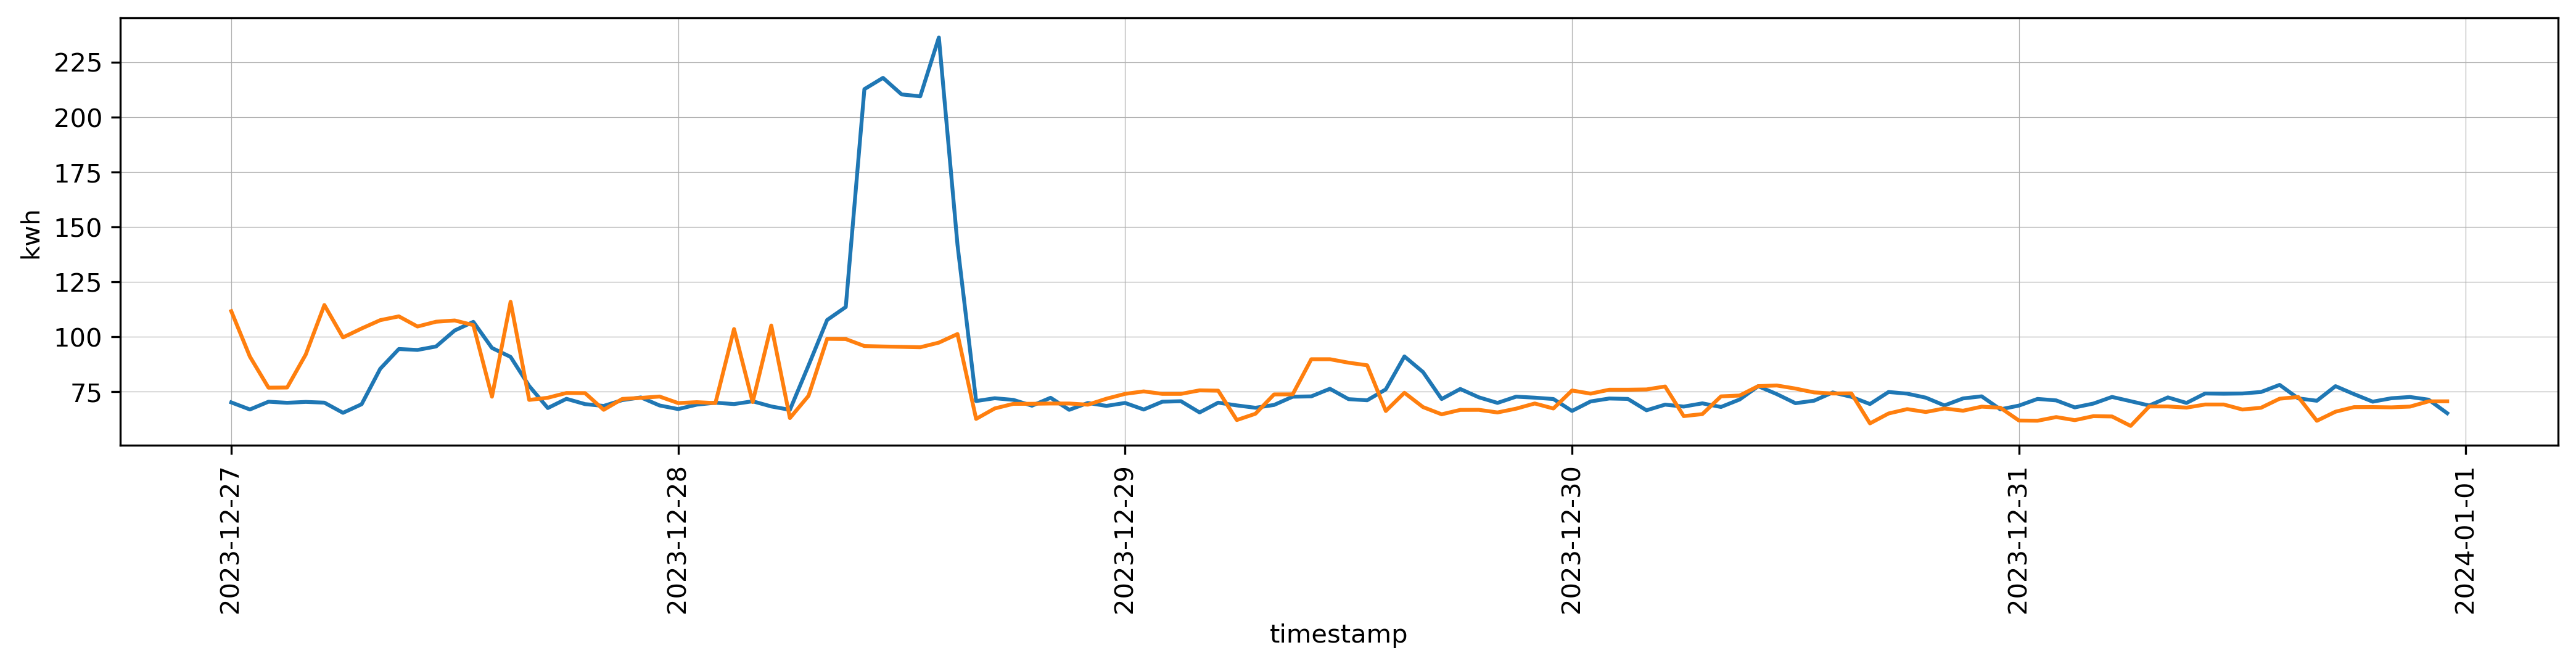

In [32]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Tunning models

In [33]:
models={}

## Tunning model cluster 0

In [34]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [35]:
# Filtrar datos por cluster
cluster = 0
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [36]:
cluster_data_train

,timestamp,kwh,Cluster,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
408,2023-01-18 00:00:00+00:00,75.91,0,0,2,1,1,18,18,3,65.66,48.01,53.02
409,2023-01-18 01:00:00+00:00,80.24,0,1,2,1,1,18,18,3,72.27,49.27,54.69
410,2023-01-18 02:00:00+00:00,78.55,0,2,2,1,1,18,18,3,65.55,47.77,48.75
411,2023-01-18 03:00:00+00:00,77.46,0,3,2,1,1,18,18,3,59.08,51.03,52.91
412,2023-01-18 04:00:00+00:00,56.51,0,4,2,1,1,18,18,3,61.55,51.31,52.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,2023-12-22 19:00:00+00:00,73.68,0,19,4,4,12,356,22,51,72.09,67.42,106.21
8540,2023-12-22 20:00:00+00:00,67.04,0,20,4,4,12,356,22,51,69.02,65.17,88.32
8541,2023-12-22 21:00:00+00:00,66.35,0,21,4,4,12,356,22,51,69.88,63.79,75.18
8542,2023-12-22 22:00:00+00:00,63.87,0,22,4,4,12,356,22,51,67.08,64.17,84.09


In [37]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:221.49733	validation_1-mae:234.38455
[100]	validation_0-mae:90.55186	validation_1-mae:100.49547
[200]	validation_0-mae:50.24050	validation_1-mae:64.93027
[300]	validation_0-mae:40.34950	validation_1-mae:61.46529
[343]	validation_0-mae:38.79829	validation_1-mae:62.47702
[0]	validation_0-mae:223.29330	validation_1-mae:224.85415
[100]	validation_0-mae:90.08021	validation_1-mae:73.69655
[200]	validation_0-mae:50.47456	validation_1-mae:38.64435
[243]	validation_0-mae:44.53050	validation_1-mae:47.04296
[0]	validation_0-mae:224.27947	validation_1-mae:223.49216
[100]	validation_0-mae:90.03754	validation_1-mae:78.75423
[200]	validation_0-mae:51.61701	validation_1-mae:41.92301
[300]	validation_0-mae:42.27943	validation_1-mae:36.81853
[358]	validation_0-mae:40.71134	validation_1-mae:37.15425
[0]	validation_0-mae:223.95943	validation_1-mae:221.21209
[100]	validation_0-mae:89.28687	validation_1-mae:101.12029
[200]	validation_0-mae:51.38385	validation_1-mae:69.04639
[300]	valida

In [38]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [39]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [250, 300, 350],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
Mejor puntuación de validación (RMSE): 90.13133895468263
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 250       -90.131339   
1                 3                 0.01                 300       -92.295238   
2                 3                 0.01                 350       -93.367867   
3                 5                 0.01                 250       -98.348930   
4                 5                 0.01                 300       -99.556152   
5                 5                 0.01                 350       -99.436181   
6                 7                 0.01                 250       -94.558608   
7                 7                 0.01                 300       -94.383551   
8                 7                 0.01                 350       -94.431319   
9                 3                 0.05

In [40]:
# Entrenar el modelo
reg_0 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [41]:
reg_0.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
models["0"]=reg_0

## Tunning model cluster 1

In [43]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [44]:
# Filtrar datos por cluster
cluster = 1
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [45]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):

    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:58.64622	validation_1-mae:68.35905
[100]	validation_0-mae:21.65838	validation_1-mae:23.65966
[200]	validation_0-mae:9.42114	validation_1-mae:17.54412
[222]	validation_0-mae:8.45639	validation_1-mae:17.87605
[0]	validation_0-mae:59.90355	validation_1-mae:78.82483
[100]	validation_0-mae:22.18312	validation_1-mae:38.02688
[200]	validation_0-mae:10.14135	validation_1-mae:24.15754
[300]	validation_0-mae:7.84578	validation_1-mae:21.98706
[398]	validation_0-mae:7.43795	validation_1-mae:21.87625
[0]	validation_0-mae:62.18114	validation_1-mae:72.59339
[100]	validation_0-mae:23.02646	validation_1-mae:24.60366
[200]	validation_0-mae:11.05260	validation_1-mae:19.93288
[222]	validation_0-mae:10.19351	validation_1-mae:20.52896
[0]	validation_0-mae:63.26530	validation_1-mae:70.01461
[100]	validation_0-mae:23.42953	validation_1-mae:27.17882
[200]	validation_0-mae:11.45036	validation_1-mae:14.50113
[300]	validation_0-mae:9.60168	validation_1-mae:11.25490
[400]	validation_0-mae:9.11

In [46]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [47]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación de validación (RMSE): 21.415857291919803
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -21.415857   
1                 3                 0.01                 350       -21.482762   
2                 3                 0.01                 400       -21.529485   
3                 5                 0.01                 300       -22.194880   
4                 5                 0.01                 350       -22.279551   
5                 5                 0.01                 400       -22.358108   
6                 7                 0.01                 300       -23.422921   
7                 7                 0.01                 350       -23.616642   
8                 7                 0.01                 400       -23.703556   
9                 3                 0.0

In [48]:
# Entrenar el modelo
reg_1 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=300,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [49]:
reg_1.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
models["1"]=reg_1

## Tunning model cluster 2

In [51]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [52]:
# Filtrar datos por cluster
cluster = 2
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [53]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:151.14055	validation_1-mae:152.39430
[100]	validation_0-mae:58.06416	validation_1-mae:60.40440
[200]	validation_0-mae:33.13511	validation_1-mae:38.20207
[255]	validation_0-mae:29.59728	validation_1-mae:38.38072
[0]	validation_0-mae:150.80006	validation_1-mae:174.37611
[100]	validation_0-mae:58.37951	validation_1-mae:76.38239
[200]	validation_0-mae:33.24638	validation_1-mae:56.19638
[287]	validation_0-mae:28.74533	validation_1-mae:57.02734
[0]	validation_0-mae:152.65817	validation_1-mae:144.53639
[100]	validation_0-mae:59.50783	validation_1-mae:52.71922
[200]	validation_0-mae:34.72032	validation_1-mae:31.23067
[300]	validation_0-mae:30.04988	validation_1-mae:29.63139
[322]	validation_0-mae:29.59073	validation_1-mae:29.73414
[0]	validation_0-mae:152.67608	validation_1-mae:160.18301
[100]	validation_0-mae:59.31465	validation_1-mae:57.93773
[200]	validation_0-mae:34.83239	validation_1-mae:32.09023
[300]	validation_0-mae:30.26825	validation_1-mae:29.37249
[321]	validati

In [54]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [55]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 400, 500,600],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 600}
Mejor puntuación de validación (RMSE): 55.950066121852785
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -58.852335   
1                 3                 0.01                 400       -57.419676   
2                 3                 0.01                 500       -57.178743   
3                 3                 0.01                 600       -57.271207   
4                 5                 0.01                 300       -57.302911   
5                 5                 0.01                 400       -56.172048   
6                 5                 0.01                 500       -55.954841   
7                 5                 0.01                 600       -55.950066   
8                 7                 0.01                 300       -59.182204   
9                 7                 0.0

In [56]:
# Entrenar el modelo
reg_2 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)

In [57]:
reg_2.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
models["2"]=reg_2

## Tunning model cluster 3

In [59]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [60]:
# Filtrar datos por cluster
cluster = 3
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [61]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:11.45697	validation_1-mae:13.09058
[50]	validation_0-mae:10.26622	validation_1-mae:15.21143
[0]	validation_0-mae:11.75374	validation_1-mae:0.58472
[49]	validation_0-mae:11.50845	validation_1-mae:3.63175
[0]	validation_0-mae:10.06071	validation_1-mae:0.88080
[49]	validation_0-mae:9.88428	validation_1-mae:14.31747
[0]	validation_0-mae:8.80779	validation_1-mae:19.97784
[50]	validation_0-mae:8.70854	validation_1-mae:20.78088
[0]	validation_0-mae:10.12073	validation_1-mae:26.37529
[49]	validation_0-mae:10.59473	validation_1-mae:28.70531


In [62]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [63]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 40, 50],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 30}
Mejor puntuación de validación (RMSE): 38.54589234744925
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                  30       -38.545892   
1                 3                 0.01                  40       -38.868200   
2                 3                 0.01                  50       -39.206365   
3                 5                 0.01                  30       -39.238932   
4                 5                 0.01                  40       -39.861411   
5                 5                 0.01                  50       -40.511946   
6                 7                 0.01                  30       -39.554045   
7                 7                 0.01                  40       -40.211411   
8                 7                 0.01                  50       -40.910052   
9                 3                 0.05 

In [64]:
# Entrenar el modelo
reg_3 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=30,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [65]:
reg_3.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
models["3"]=reg_3

## Final analysis

In [67]:
len(models)

4

In [73]:
import time
start_time = time.time()
# Inicializar DataFrames para resultados
train_results = pd.DataFrame()
test_results = pd.DataFrame()

# Inferencia por cluster usando data_clustered
for cluster in data_clustered['Cluster'].unique():
    print(f"\nInferencia modelo para el Cluster {cluster}...")
    # Filtrar el subconjunto de test para el cluster actual
    test_cluster = test[test['Cluster'] == cluster]
    if not test_cluster.empty:
        inference = inference_models(cluster, test_cluster, models)
        test_results = pd.concat([test_results, inference], ignore_index=True)
    else:
        print(f"No hay datos de test para el Cluster {cluster}.")

# Calcular el tiempo de ejecución
execution_time = time.time() - start_time

# Imprimir el tiempo de ejecución
print(f"Tiempo de ejecución: {execution_time} segundos")


Inferencia modelo para el Cluster 1...

Inferencia modelo para el Cluster 2...
No hay datos de test para el Cluster 2.

Inferencia modelo para el Cluster 0...
No hay datos de test para el Cluster 0.

Inferencia modelo para el Cluster 3...
No hay datos de test para el Cluster 3.
Tiempo de ejecución: 0.006520748138427734 segundos


In [74]:
# Ordenar resultados por timestamp
test_results = test_results.sort_values(by="timestamp")

# Calcular métricas de evaluación
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))
smape_score = smape(test_results["kwh"], test_results["predictions"])

# Mostrar resultados finales
print("\nResultados:")
print("RMSE:", mse)
print("SMAPE:", smape_score)


Resultados:
RMSE: 32.45684640410657
SMAPE: 0.15951410189806278


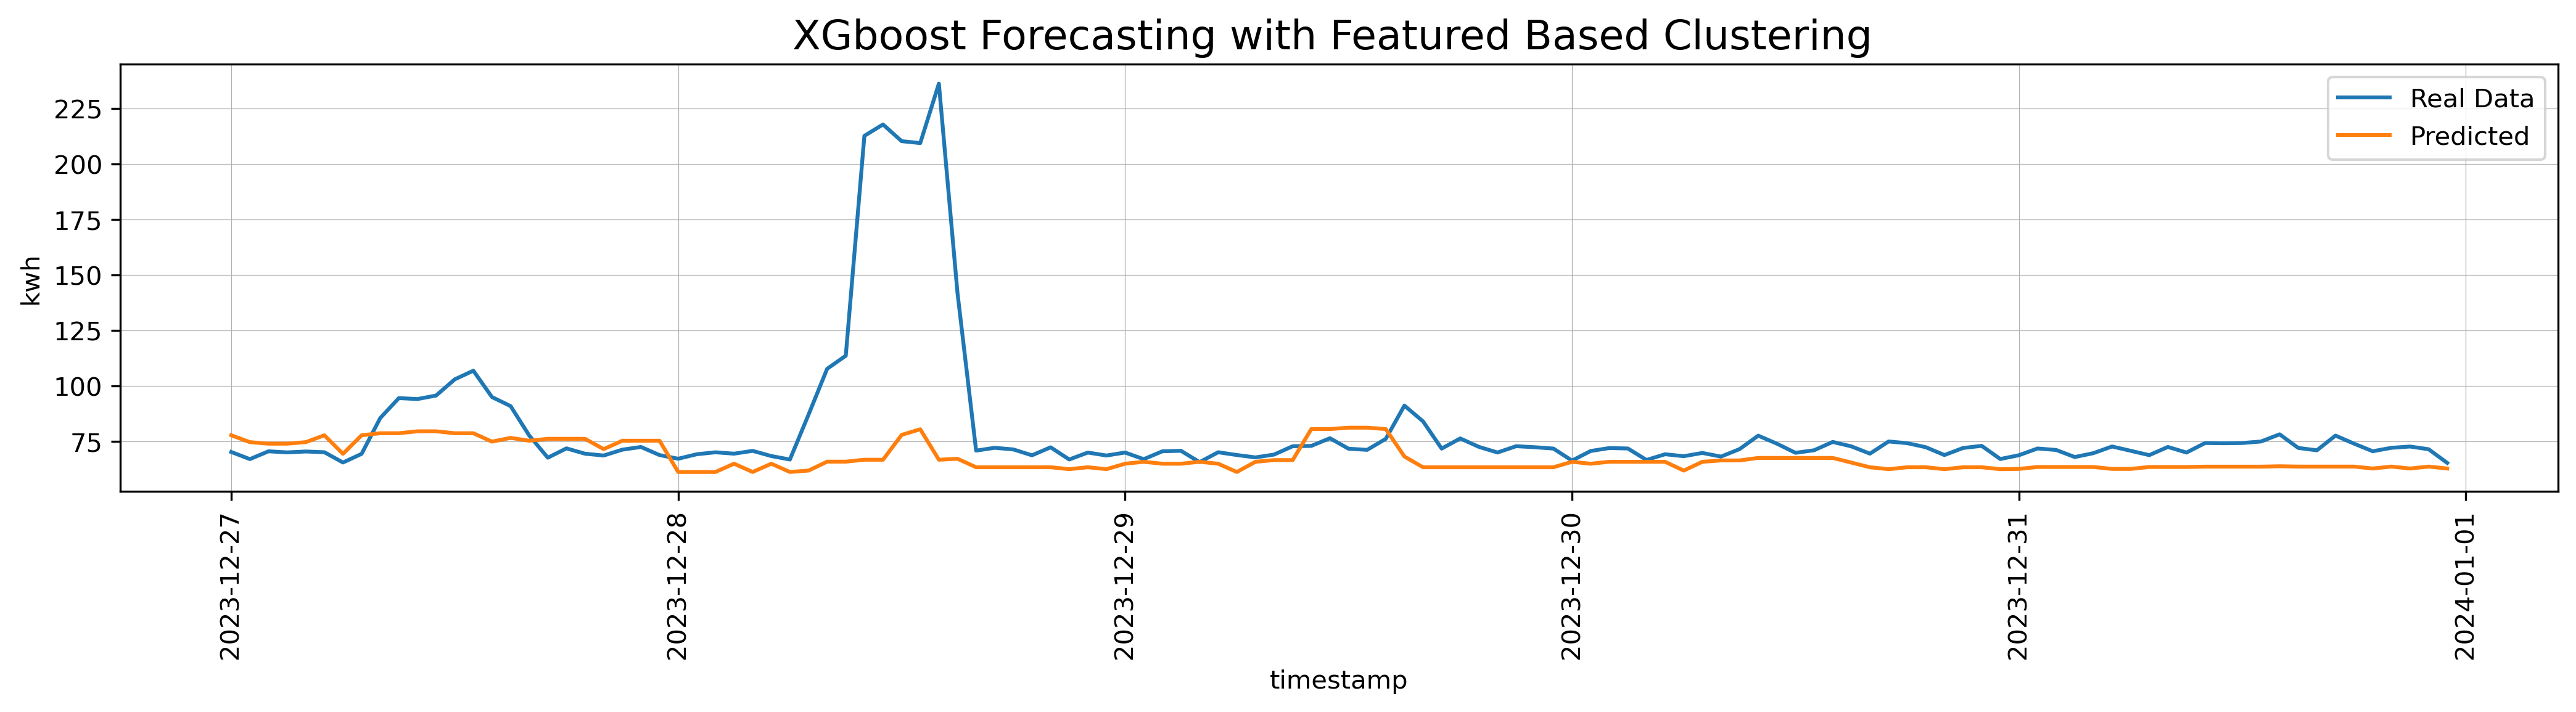

In [70]:
# Visualización
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh', label='Real Data')
sns.lineplot(data=test_results, x='timestamp', y='predictions', label='Predicted')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.title('XGboost Forecasting with Featured Based Clustering ', fontsize=16)
plt.legend()
plt.show()